In [2]:
from qiskit.visualization import circuit_drawer
import os, json, logging, time, dataclasses
import numpy as np
from collections import Counter
from datetime import datetime

from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import PauliList, SparsePauliOp
from scipy.sparse.linalg import eigsh

from multiprocessing import Pool

import wesszumino as wz

In [13]:
N=3
cutoff=2
a=1.0
potential = 'linear'
boundary_condition = 'dirichlet'
c=0.0
x_max =8.0
H_pauli, num_qubits, basis_info = wz.build_wz_hamiltonian_with_qft_parts(cutoff=cutoff, N=N, a=a, potential=potential, boundary_condition=boundary_condition,c=c, x_max=x_max)

In [14]:
qps = int(np.log2(cutoff)) + 1
fermion_qubits = [(s + 1) * qps - 1 for s in range(N)] 
basis = [0] * num_qubits

start = 1 if (N % 2 == 0) else 0
for s in range(N):
    base = s * qps
    basis[base + 0] = start ^ (s & 1) 
    if qps >= 2:
        basis[base + 1] = 1

basis_state = basis

In [15]:
basis_state

[0, 1, 1, 1, 0, 1]

In [16]:
num_trotter_steps = 1

qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)

for q, bit in enumerate(reversed(basis_state)):
    if bit == 1:
        qc.x(q)

nb = int(np.log2(2))
n_per_site = int(1+nb)

qf_sites = []
qb_sites = []
for n in range(N):
    base = n * n_per_site
    qb = [qc.qubits[base + i] for i in range(nb)]
    qf = qc.qubits[base + nb]

    qf_sites.append(qf)
    qb_sites.append(qb)

dt_step = 1.0 / num_trotter_steps
wz.append_wz_split_operator_evolution(qc, qf_sites, qb_sites, basis_info, dt_step, num_trotter_steps, boundary_condition=boundary_condition)

qc.measure_all()

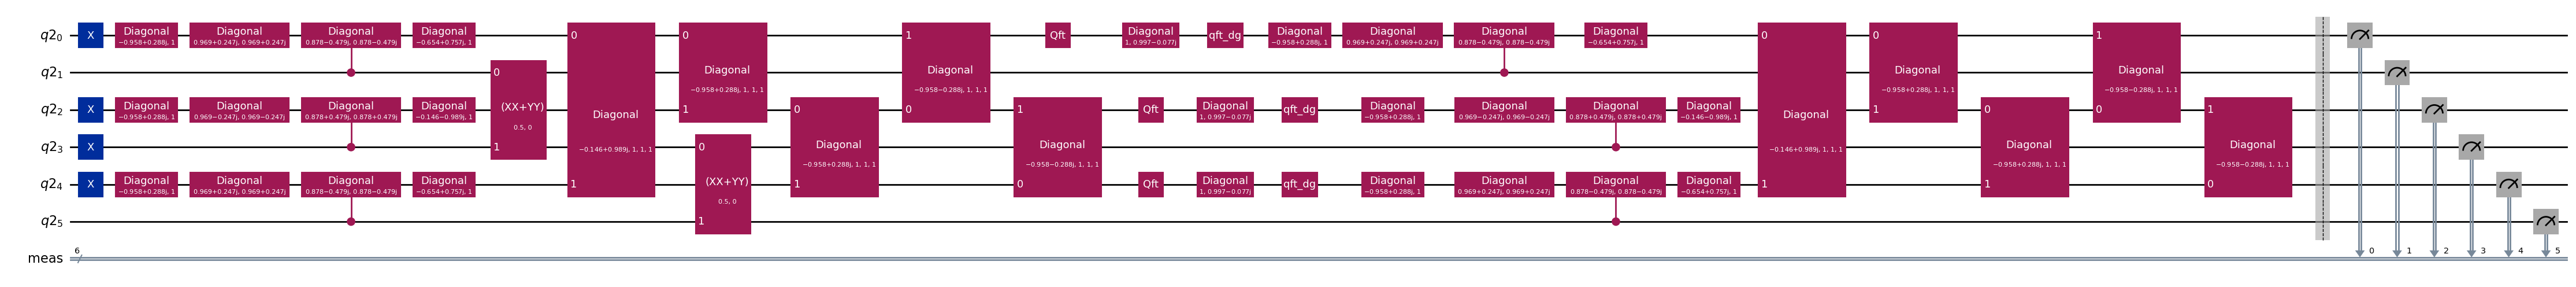

In [17]:
circuit_drawer(
    qc,
    output="mpl",
    fold=-1,
    idle_wires=False,
    style={"dpi": 300},
    filename="circuit_full.png",
)
